In [1]:
import dotenv
dotenv.load_dotenv()

# import os
# os.getenv("ANTHROPIC_API_KEY")

True

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env(os.getenv("ANTHROPIC_API_KEY"))
_set_env(os.getenv("TAVILY_API_KEY"))

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [5]:
graph_builder.add_edge(START, "chatbot")

In [6]:
graph_builder.add_edge("chatbot", END)

In [7]:
graph = graph_builder.compile()

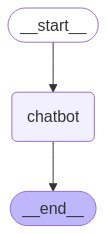

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything.
Goodbye!


# Part 2: Enhancing the chatbot with tools

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=2, tavily_api_key=os.getenv("TAVIL_API_KEY"))
tools = [tavily_tool]
tavily_tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'LangGraph Quickstart - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/',
  'content': 'In LangGraph, nodes are Python functions that take the current state, do some work, and return an updated state. Next, we define the nodes, each representing a',
  'score': 0.92995757},
 {'title': 'A Comprehensive Guide About Langgraph: Code Included - Ionio',
  'url': 'https://www.ionio.ai/blog/a-comprehensive-guide-about-langgraph-code-included',
  'content': 'A node can be any function or tool your agent uses in langgraph and these nodes are connected with other nodes using edges. Every workflow ends with a “END”',
  'score': 0.8872928}]

In [11]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [12]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tavily_tool])
graph_builder.add_node("tools", tool_node)

In [13]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

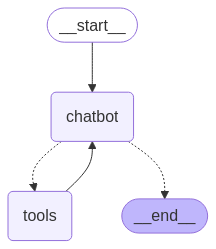

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I assist you today? I'm here to help with any questions or tasks you may have.
Assistant: [{'text': "To get the latest information about Elon Musk, I'll need to use the search function to find current news. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_01F6SL8zYiQwxTCgsfu7kT6p', 'input': {'query': 'Elon Musk latest news'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"title": "Elon Musk News | Today's Latest Stories - Reuters", "url": "https://www.reuters.com/business/elon-musk/", "content": "India's telecom regulator plans to recommend that satellite broadband spectrum be allotted for around five years to assess initial market adoption, defying Elon Musk's Starlink, which is seeking a 20-year permit, said a senior government source. President Donald Trump said on Tuesday he will label violence against Tesla dealerships domestic terrorism as he appeared with Tesla CEO Elon Musk to show support amid recent \"Tesla Takedown\

# Memory via checkpointing

In [16]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [17]:
graph = graph_builder.compile(checkpointer=memory)

In [46]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
config = {"configurable": {"thread_id": "1"}}

In [20]:
user_input = "Hi there! My name is Ethan."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Hi there! My name is Ethan.
================================== Ai Message ==================================

Hello Ethan! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?


In [21]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, Ethan! I remember that you introduced yourself as Ethan. Is there anything in particular you'd like to talk about or any questions you have? I'm here to help with a wide range of topics or tasks.


In [22]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I apologize, but I don't have any prior context or memory of your name. As an AI assistant, I start each conversation fresh without retaining information from previous interactions. Is there something specific you'd like me to call you for this conversation?


In [23]:
snapshot=graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Ethan.', additional_kwargs={}, response_metadata={}, id='e9ce2c06-37d7-4753-b5a7-90fc3f6a043b'), AIMessage(content="Hello Ethan! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?", additional_kwargs={}, response_metadata={'id': 'msg_01W1imbKaMAJud73Z6TLuJja', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 407, 'output_tokens': 34}, 'model_name': 'claude-3-5-sonnet-20240620'}, id='run-2c1285e8-c70c-4dfe-9c07-1078122c2270-0', usage_metadata={'input_tokens': 407, 'output_tokens': 34, 'total_tokens': 441, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='559c45e0-6cb7-41e4-9ca3-192bd2342920'), AIMessage(content="Of course,

In [24]:
snapshot.next

()

# Human in the loop

In [1]:
from langgraph.types import Command, interrupt

In [2]:
from langgraph.graph import StateGraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [3]:
def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}
    
graph_builder.add_node("chatbot", chatbot)

In [4]:
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]
    

In [5]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import START
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_anthropic import ChatAnthropic

tavily_tool = TavilySearchResults(max_results=2)
tools = [tavily_tool, human_assistance]
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
    

In [7]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

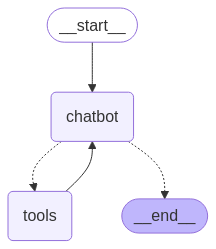

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'id': 'toolu_01UMVfcMCgkVNRBHrJsJAruX', 'input': {'query': 'I need expert guidance for building an AI agent.'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01UMVfcMCgkVNRBHrJsJAruX)
 Call ID: toolu_01UMVfcMCgkVNRBHrJsJAruX
  Args:
    query: I need expert guidance for building an AI agent.


In [10]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [11]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'id': 'toolu_01UMVfcMCgkVNRBHrJsJAruX', 'input': {'query': 'I need expert guidance for building an AI agent.'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01UMVfcMCgkVNRBHrJsJAruX)
 Call ID: toolu_01UMVfcMCgkVNRBHrJsJAruX
  Args:
    query: I need expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Does this help provide the expert guidance you were looking for? Let me know if you have any other questions - I'm happy to assist further or request additional help from the human experts if needed.


# Advanced State

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [13]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt

@tool
def human_assistance(name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
		{
			"question": "Is this correct?",
			"name": name,
			"birthday": birthday
		}
	)
    
    if human_response.get('correct', '').lower().startswith('y'):
        verified_name = name
        verified_birthday = birthday
        response = 'Correct'
        
    else:
        verified_name = human_response.get('name', name)
        verified_birthday = human_response.get('birthday', birthday)
        response = f"Made a correction: {human_response}"
        
    state_update = {
		'name': verified_name,
		'birthday': verified_birthday,
		'messages': [ToolMessage(content=response, tool_call_id=tool_call_id)]
	}
    
    return Command(update=state_update)

In [14]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [15]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================

[{'text': "Certainly! I'll start by searching for information about LangGraph's release date using the Tavily search function. Then, I'll use the human_assistance tool for review as you requested.\n\nLet's begin with the search:", 'type': 'text'}, {'id': 'toolu_01WtieWMWbuKqjzfy151xU1y', 'input': {'query': 'LangGraph release date'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01WtieWMWbuKqjzfy151xU1y)
 Call ID: toolu_01WtieWMWbuKqjzfy151xU1y
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Announcing LangGraph v0.1 & LangGraph Cloud: 

In [16]:
# The above execution stops at the interrupt where the agent is asking the human to review the name and date that it found for langgraph's birthday.
# We'll provide our review here:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Based on the search results, it appears that LangGraph has had multiple releases. The earliest mention I can find is about LangGraph v0.1, which was announced in a blog post dated June 27, 2024. However, it's important to note that this information might not be entirely accurate or up-to-date, as the search results seem to include future dates (which is likely an error in the data).\n\nTo get a more accurate review of this information, let's use the human_assistance tool as you requested. For this, we need to provide a name and birthday. Since we don't have specific information for these fields, I'll use placeholder values that indicate we're asking about LangGraph.", 'type': 'text'}, {'id': 'toolu_019zEoj8BNu3XDcBhgnSrSgD', 'input': {'name': 'LangGraph', 'birthday': '2024-06-27'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_019zEoj8BNu3XDcBhgnSrSgD)
 

In [ ]:
# We can verify that these new dates are reflected in the state.

snapshot = graph.get_state(config={"configurable": {"thread_id": "1"}})
{k:v for k,v in snapshot.values.items() if k in ('name', 'birthday')}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

In [30]:
# We can also update these values directly from outside the graph execution runtime
graph.update_state(config={"configurable": {"thread_id": "1"}},
                   values={
                       "name": "LangGraph (library)",
                       "birthday": "Jan 17, 2024"
                   })


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f01964b-94c9-68e2-8006-8f8a9e10a3cd'}}

In [32]:
# And then check again to verify the change took place
snapshot = graph.get_state(config={"configurable": {"thread_id": "1"}})
{k:v for k,v in snapshot.values.items() if k in ('name', 'birthday')}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

# Time Travel

In [34]:
# Using the simple chatbot with tools from part 3:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

[ConfigurableFieldSpec(id='checkpoint_id', annotation=typing.Optional[str], name='Checkpoint ID', description='Pass to fetch a past checkpoint. If None, fetches the latest checkpoint.', default=None, is_shared=True, dependencies=None),
 ConfigurableFieldSpec(id='checkpoint_ns', annotation=<class 'str'>, name='Checkpoint NS', description='Checkpoint namespace. Denotes the path to the subgraph node the checkpoint originates from, separated by `|` character, e.g. `"child|grandchild"`. Defaults to "" (root graph).', default='', is_shared=True, dependencies=None),
 ConfigurableFieldSpec(id='thread_id', annotation=<class 'str'>, name='Thread ID', description=None, default='', is_shared=True, dependencies=None)]

In [36]:
# Let's simulate some conversation:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "Certainly! To provide you with up-to-date and accurate information about LangGraph, I'll need to use the search function available to me. Let me search for that information for you.", 'type': 'text'}, {'id': 'toolu_01LcVddR4Rk3p6Nc27RRLJCQ', 'input': {'query': 'LangGraph framework for language models'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01LcVddR4Rk3p6Nc27RRLJCQ)
 Call ID: toolu_01LcVddR4Rk3p6Nc27RRLJCQ
  Args:
    query: LangGraph framework for language models
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph: A Framework for Building Stateful Multi-Agent LLM ...", "url": "https://medium.com/@

In [40]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

I apologize for the confusion. I now realize you've repeated your previous statement. Thank you for reiterating your interest in building an autonomous agent with LangGraph. Since you've confirmed your intention, let me provide some practical next steps to help you get started with your project:

1. Set Up Your Development Environment:
   - Install Python if you haven't already.
   - Set up a virtual environment for your project.
   - Install LangGraph and its dependencies. You can typically do this using pip:
     ```
     pip install langgraph
     ```
   - You might also want to install LangChain, as it often works well in conjunction with LangGraph:
     ```
     pip install langchain
     ```

2. Familiarize Yourself with the Basics:
   - Review the LangGr

In [47]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 2:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
-------------------------------------------------------

In [48]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f019657-352a-683a-8001-8e735d11fe84'}}


In [49]:
# Time travel back to before the nth step defined above:
for event in graph.stream(None, config=to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Certainly! To provide you with up-to-date and accurate information about LangGraph, I'll need to use the search function available to me. Let me search for that information for you.", 'type': 'text'}, {'id': 'toolu_01LcVddR4Rk3p6Nc27RRLJCQ', 'input': {'query': 'LangGraph framework for language models'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01LcVddR4Rk3p6Nc27RRLJCQ)
 Call ID: toolu_01LcVddR4Rk3p6Nc27RRLJCQ
  Args:
    query: LangGraph framework for language models
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph: A Framework for Building Stateful Multi-Agent LLM ...", "url": "https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03", "content": "LangGraph is a powerful Python library 